In [246]:
import numpy as np
import pandas as pd
import thermo
import chemicals
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS, VaporPressure, PropertyCorrelationsPackage
from thermo import FlashVLN, ViscosityLiquidMixture, ViscosityGasMixture, SurfaceTensionMixture, FlashVL, Mixture
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB
import pint
from thermo import PR

ureg = pint.UnitRegistry()

https://www.youtube.com/watch?v=pQFBmqbsh9Y&ab_channel=AliAl-Matar

https://www.researchgate.net/figure/Phase-envelopes-for-propane-methane-mixtures_fig12_241789652

https://www.chem.mtu.edu/chem_eng/faculty/memullins/course/BubblePoint/Bubble%20Point.htm

https://thermo.readthedocs.io/activity_coefficients.html

https://thermo.readthedocs.io/property_objects.html

## I got vapor P calculation for pure component, Figure out for mixture using Van Laar activity coefficients

In [96]:
def cas_to_name(cas):
    if not isinstance(cas, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([cas]).names[0]

def name_to_cas(name):
    if not isinstance(name, str):
        raise ValueError("Input must be a string")    
    return ChemicalConstantsPackage.constants_from_IDs([name]).CASs[0]

def F_to_R(F):
    return F + 459.67

def R_to_F(R):
    return R - 459.67

def C_to_K(C):
    return C + 273.15

def F_to_C(F):
    return (F - 32) * 5 / 9

def K_to_C(K):
    return K - 273.15

def gal_to_bbl(gal):
    return gal / 42

def bbl_to_gal(bbl):
    return bbl * 42

def psi_to_Pa(psi):
    return psi * 6894.745

def Pa_to_bar(Pa):
    return Pa / 100000

def Pa_to_psi(pa):
    return pa / 6894.745

def Pa_to_mmHg(Pa):
    return Pa / 133.322

def mmHg_to_Pa(mmHg):
    return mmHg / 0.0075

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

In [3]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, PropertyCorrelationsPackage
from thermo import FlashVLN
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB

In [131]:
def psi_to_Pa(psi):
    return psi * 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def Pa_to_psi(pa):
    return pa / 6894.745

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

comp = dict([
    ('oxygen', 0.21),
    ('nitrogen', 0.78),
    ('argon', 0.01),
])
comp = dict([
    ('methane', 0.2), 
    ('propane', 0.2),
    ('hexane', .6),
    ('water', 0.),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
#eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.
flashN = FlashVL(constants, properties, liquid=liq, gas=gas) # if dealing with water, fill [liq, liq] twice.

P = psi_to_Pa(100)
T = F_to_K(100)

res = flashN.flash(T=T, P=P, zs=list(comp.values()))
zs = list(comp.values())

In [133]:
eos_kwargs

{'Tcs': [190.564, 369.89, 507.82, 647.096],
 'Pcs': [4599200.0, 4251200.0, 3044100.0, 22064000.0],
 'omegas': [0.01142, 0.1521, 0.3, 0.3443],
 'kijs': [[0.0, 0.0119, 0.04, 0],
  [0.0119, 0.0, 0.0007, 0],
  [0.04, 0.0007, 0.0, 0],
  [0, 0, 0, 0.0]]}

In [23]:
comp = dict([
    ('m-xylene', 1.),
    ('methane', 0.0), 
    ('propane', 0.0),
    ('water', 0.),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
zs = list(comp.values())
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

m = Mixture(comp.keys(), zs=zs)

P = 100000

Tbs = m.Tbs
Tcs = m.Tcs
Pcs = m.Pcs
omegas = m.omegas

T = 300

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs, zs=zs)
PR_obj = PRMIX(**eos_kwargs, P=P, T=T)

Pa_to_bar(VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj).calculate(T, 'SANJARI'))

0.011814742682792362

In [24]:
Pa_to_bar(VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0]).calculate(T, 'SANJARI'))

0.011814742682792362

In [105]:
VaporPressure(CASRN='64-17-5', load_data=False)

VaporPressure(CASRN="64-17-5", extrapolation="AntoineAB|DIPPR101_ABC", method=None)

# Vapor Pressure Tutorial - start

In [253]:
cas = name_to_cas('ethanol')

a = VaporPressure(CASRN=cas, load_data=True)
T = 331
attrs = vars(a)
print(', '.join("%s: %s" % item for item in attrs.items()))

CASRN: 64-17-5, Tb: None, Tc: None, Pc: None, omega: None, eos: None, local_methods: {}, extrapolation_coeffs: {}, tabular_data: {'VDI_TABULAR': ([300.0, 320.0, 340.0, 351.39, 375.0, 400.0, 425.0, 450.0, 475.0, 513.9], [8840.0, 25460.0, 63540.0, 101330.0, 239880.0, 524460.0, 1029280.0, 1850550.0, 3096320.0, 6148000.0])}, tabular_data_interpolators: {}, T_limits: {'ANTOINE_WEBBOOK': (364.8, 513.91), 'WAGNER_MCGARRY': (293.0, 513.92), 'WAGNER_POLING': (159.05, 513.92), 'ANTOINE_POLING': (276.5, 369.54), 'DIPPR_PERRY_8E': (159.05, 514.0), 'COOLPROP': (159.10000000000002, 514.71), 'VDI_TABULAR': (300.0, 513.9), 'VDI_PPDS': (159.05, 513.9), 'LANDOLT': (341.0, 514.0), 'HEOS_FIT': (159.0, 514.71)}, all_methods: {'ANTOINE_WEBBOOK', 'DIPPR_PERRY_8E', 'HEOS_FIT', 'ANTOINE_POLING', 'VDI_PPDS', 'WAGNER_MCGARRY', 'VDI_TABULAR', 'LANDOLT', 'WAGNER_POLING', 'COOLPROP'}, ANTOINE_WEBBOOK_coefs: [22.853871, 3298.513, -61.819], WAGNER_MCGARRY_Pc: 6130870.0, WAGNER_MCGARRY_Tc: 513.92, WAGNER_MCGARRY_Tmin:

In [254]:
a.T_limits 

{'ANTOINE_WEBBOOK': (364.8, 513.91),
 'WAGNER_MCGARRY': (293.0, 513.92),
 'WAGNER_POLING': (159.05, 513.92),
 'ANTOINE_POLING': (276.5, 369.54),
 'DIPPR_PERRY_8E': (159.05, 514.0),
 'COOLPROP': (159.10000000000002, 514.71),
 'VDI_TABULAR': (300.0, 513.9),
 'VDI_PPDS': (159.05, 513.9),
 'LANDOLT': (341.0, 514.0),
 'HEOS_FIT': (159.0, 514.71)}

In [255]:
Pa_to_mmHg(a.calculate(T=T, method='HEOS_FIT'))

318.1777286027808

In [256]:
Pa_to_mmHg(a.calculate(T=T, method='WAGNER_POLING'))

319.4358438471452

In [257]:
Pa_to_mmHg(a.calculate(T=T, method='WAGNER_MCGARRY'))

319.21306632378105

In [258]:
Ts = np.arange(160, 569, 10)
vps = [Pa_to_bar(a.calculate(T=T, method='HEOS_FIT')) for T in Ts]

In [262]:
K_to_C(chemicals.Tc(CASRN=cas))

241.56000000000006

In [264]:
Pa_to_bar(chemicals.Pc(CASRN=cas))

62.68

Tc = 241.6C, Pc = 62.7bar
Compare: https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-properties-C2H6O-d_2027.html


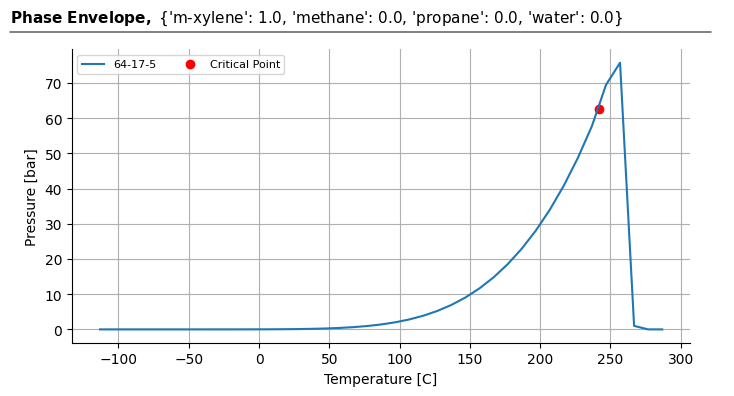

In [271]:


fig, ax = plt.subplots(figsize=(7, 4))

x = Ts
x = [K_to_C(item) for item in x]
T_unit = 'C'
P_unit ='bar'

Tc = K_to_C(chemicals.Tc(CASRN=cas))
Pc = Pa_to_bar(chemicals.Pc(CASRN=cas))

ax.plot(x, vps, label=cas)
ax.scatter(Tc, Pc, label='Critical Point', color='red')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

print('Tc = %.1fC, Pc = %.1fbar' % (Tc, Pc))
print('Compare: https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-properties-C2H6O-d_2027.html')

fig.tight_layout()

### load_data performance comparison - not much difference

In [229]:
from chemicals import vapor_pressure
import timeit

T = 331

In [230]:
start_time = timeit.default_timer()

for i in range(10000):

    cas = name_to_cas('ethanol')
    a = VaporPressure(CASRN=cas, load_data=False)

    WAGNER_POLING_params = vapor_pressure.Psat_values_WagnerPoling[vapor_pressure.Psat_data_WagnerPoling.index.get_loc(cas)].tolist()

    a.WAGNER_POLING_coefs = WAGNER_POLING_params[:4]
    a.WAGNER_POLING_Tc = WAGNER_POLING_params[4]
    a.WAGNER_POLING_Pc = WAGNER_POLING_params[5]

    Pa_to_mmHg(a.calculate(T=T, method='WAGNER_POLING'))

print(timeit.default_timer() - start_time)

9.467768799999249


In [231]:
start_time = timeit.default_timer()
for i in range(10000):
    
    a = VaporPressure(CASRN=name_to_cas('ethanol'), load_data=True)
    Pa_to_mmHg(a.calculate(T=T, method='WAGNER_POLING'))
    
print(timeit.default_timer() - start_time)

10.046220399999584


In [202]:
WAGNER_POLING_params[6]

159.05

In [199]:
a

VaporPressure(CASRN="64-17-5", extrapolation="AntoineAB|DIPPR101_ABC", method=None)

In [195]:
a.Tmin

159.0

In [187]:
from chemicals import vapor_pressure

vapor_pressure.Psat_values_WagnerPoling[vapor_pressure.Psat_data_WagnerPoling.index.get_loc(name_to_cas('ethanol'))].tolist()

[-8.68587, 1.17831, -4.8762, 1.588, 513.92, 6132000.0, 159.05, 513.92]

# Vapor Pressure Tutorial - end

In [178]:
vapor_pressure.Psat_values_WagnerPoling[vapor_pressure.Psat_data_WagnerPoling.index.get_loc(name_to_cas('ethanol'))].tolist()

[-8.68587, 1.17831, -4.8762, 1.588, 513.92, 6132000.0, 159.05, 513.92]

In [177]:
from chemicals import vapor_pressure

In [146]:
Pa_to_psi(VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0]).calculate(T, 'SANJARI'))

153675109.74916753

In [142]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj).calculate(T, 'SANJARI')

153675109.74916753

In [144]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj, load_data=True).calculate(T, 'ANTOINE_WEBBOOK')

AttributeError: 'VaporPressure' object has no attribute 'ANTOINE_WEBBOOK_coefs'

In [130]:
zs = [0.2, 0.2, 0.6]

P = psi_to_Pa(100)
T = F_to_K(100)

mix = ['methane', 'toluene', 'm-Xylene']

Tbs = Mixture(mix, zs=zs).Tbs
Tcs = Mixture(mix, zs=zs).Tcs
Pcs = Mixture(mix, zs=zs).Pcs
omegas = Mixture(['benzene', 'toluene', 'm-Xylene'], zs=zs).omegas


PR_obj = PRMIX(Tcs=Tcs, Pcs=Pcs, omegas=omegas, zs=zs, P=P, T=T, kijs=kijs)

In [138]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0]).calculate(T, 'SANJARI')

153675109.74916753

In [139]:
VaporPressure(Tb=Tbs[0], Tc=Tcs[0], Pc=Pcs[0], omega=omegas[0], eos=PR_obj).calculate(T, 'SANJARI')

153675109.74916753

In [111]:
Mixture(mix, zs=zs).fgcs

AttributeError: 'Mixture' object has no attribute 'fgcs'

In [110]:
Tcs

[190.564, 591.75, 616.89]

In [106]:
zs

[0.2, 0.2, 0.6, 0.0]

In [104]:
zs

[0.2, 0.2, 0.6, 0.0]

In [99]:
Tcs

190.564

In [ ]:
fig = flashN.plot_TP(zs=zs, show=False)
ax = fig.get_axes()[0]
ax.set_yscale('linear')

fig.savefig('PT.png')

In [6]:
Tcs = np.array((res.Tcs))
zss = np.array(zs)
sum(Tcs * zss)

416.7828

In [7]:
res.pseudo_Tc()

416.7828

In [8]:
res.CASs

['74-82-8', '74-98-6', '110-54-3', '7732-18-5']

In [85]:
T = F_to_K(72.5)
T = C_to_K(-70)

Pa_to_psi(Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Pbubble)

747.7472372660187

In [97]:
name_to_cas('methane')

'74-82-8'

In [125]:
VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas, eos=PR_obj).calculate(T, 'SANJARI')

92870952.05962054

In [126]:
VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI')

92870952.05962054

In [93]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).CASs

['74-82-8', '74-98-6']

In [122]:
for t in range(-100, 25, 5):
    T = C_to_K(t)

    mix = ['methane', 'toluene', 'm-Xylene']

    Tbs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Tbs[0]
    Tcs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Tcs[0]
    Pcs = Mixture(mix, ws=[0.2, 0.2, 0.6]).Pcs[0]
    omegas = Mixture(['benzene', 'toluene', 'm-Xylene'], ws=[0.2, 0.2, 0.6]).omegas[0]

    vp = Pa_to_psi(VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI'))
    
    print('T = %d C, Vp = %.3f' % (K_to_C(T), vp))

T = -100 C, Vp = 342.822
T = -95 C, Vp = 419.340
T = -90 C, Vp = 508.209
T = -85 C, Vp = 610.910
T = -80 C, Vp = 729.123
T = -75 C, Vp = 864.757
T = -70 C, Vp = 1019.993
T = -65 C, Vp = 1197.334
T = -60 C, Vp = 1399.658
T = -55 C, Vp = 1630.283
T = -50 C, Vp = 1893.041
T = -45 C, Vp = 2192.365
T = -40 C, Vp = 2533.395
T = -35 C, Vp = 2922.092
T = -30 C, Vp = 3365.386
T = -25 C, Vp = 3871.338
T = -20 C, Vp = 4449.344
T = -15 C, Vp = 5110.366
T = -10 C, Vp = 5867.214
T = -5 C, Vp = 6734.876
T = 0 C, Vp = 7730.921
T = 5 C, Vp = 8875.967
T = 10 C, Vp = 10194.253
T = 15 C, Vp = 11714.317
T = 20 C, Vp = 13469.817


In [89]:
Tcs

190.564

In [68]:
Pa_to_bar(VaporPressure(Tb=Tbs, Tc=Tcs, Pc=Pcs, omega=omegas).calculate(T, 'SANJARI'))

23.636698659822535

In [15]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Pbubble

250300919.66963524

In [18]:
Mixture(['methane', 'propane'], ws=[0.5, 0.5], T=T).Psats

[341038236.1417108, 892897.0239571161]

In [19]:
Mixture(['benzene', 'toluene'], ws=[0.5, 0.5], T=320).Psats

[32069.698020585838, 10726.733206586498]

In [10]:
Pa_to_psi(res.pseudo_Pc())

521.6349553174193

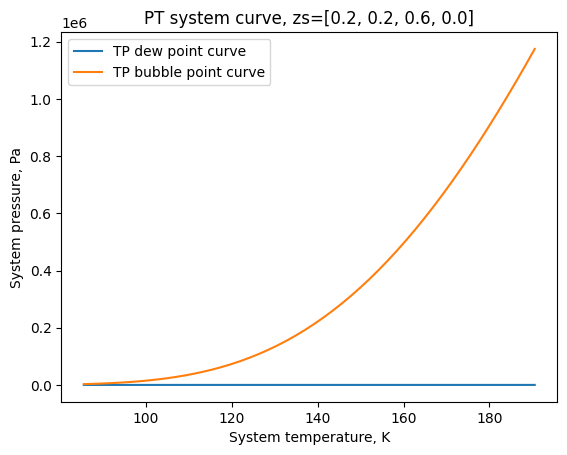

In [2]:
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, PropertyCorrelationsPackage
from thermo import FlashVLN
import matplotlib.pyplot as plt
from thermo.interaction_parameters import IPDB

def psi_to_Pa(psi):
    return psi * 6894.745

def F_to_K(F):
    return (F - 32) * 5/9 + 273.15

def Pa_to_psi(pa):
    return pa / 6894.745

def K_to_F(K):
    return (K - 273.15) * 1.8 + 32

comp = dict([
    ('methane', 0.2), 
    ('propane', 0.2),
    ('hexane', .6),
    ('water', 0.),
])

total_comp = sum(comp.values())
if total_comp > 1:
    comp = {k: v / total_comp for k, v in comp.items()}
    
constants, properties = ChemicalConstantsPackage.from_IDs(comp.keys())
kijs = IPDB.get_ip_asymmetric_matrix('ChemSep PR', constants.CASs, 'kij')

eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas, kijs=kijs)
gas = CEOSGas(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
liq = CEOSLiquid(PRMIX, eos_kwargs, HeatCapacityGases=properties.HeatCapacityGases)
flashN = FlashVLN(constants, properties, liquids=[liq, liq], gas=gas) # if dealing with water, fill [liq, liq] twice.

P = psi_to_Pa(100)
T = F_to_K(100)

res = flashN.flash(T=T, P=P, zs=list(comp.values()))

zs = list(comp.values())

fig = flashN.plot_TP(zs=zs, show=False)
ax = fig.get_axes()[0]
ax.set_yscale('linear')

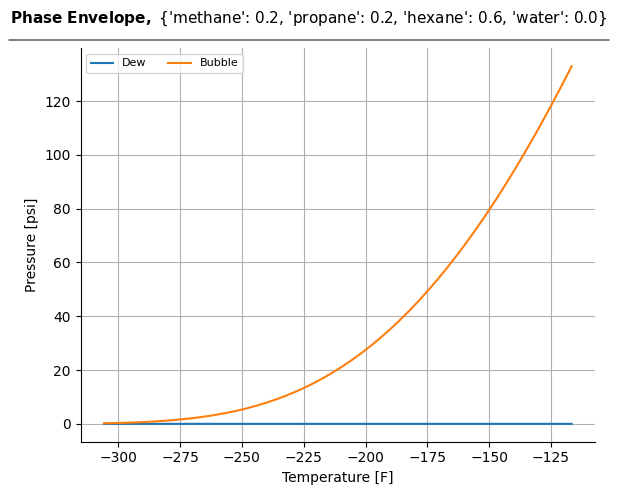

In [81]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True)
res = flashN.flash(T=T, P=P, zs=list(comp.values()))

fig, ax = plt.subplots(figsize=(6, 5))

x = Ts
x = [K_to_F(item) for item in x]
T_unit = 'F'
#T_crit = res.pseudo_Tc()
#T_crit = K_to_F(res.pseudo_Tc())

P_dews = [Pa_to_psi(item) for item in P_dews]
P_bubbles = [Pa_to_psi(item) for item in P_bubbles]
P_unit ='psi'

ax.plot(x, P_dews, label='Dew')
ax.plot(x, P_bubbles, label='Bubble')

ax.set_xlabel('Temperature [%s]' % T_unit)
ax.set_ylabel('Pressure [%s]' % P_unit)

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(ncol=2, fontsize=8)
    
def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

comp = {k: round(v, 2) for k, v in comp.items()}

bold_txt = setbold('Phase Envelope, ')
plain_txt = str(comp)
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

fig.tight_layout()

In [65]:
Ts, P_dews, P_bubbles, branch_Ps = flashN.plot_TP(zs=zs, show=False, values=True)

In [20]:
res

EquilibriumState(T=310.92777777777775, P=689474.5, zs=[0.2, 0.2, 0.6, 0.0], betas=[0.2747350826525651, 0.7252649173474349], gas=<CEOSGas, T=310.928 K, P=689474 Pa>, liquids=[CEOSLiquid(eos_class=PRMIX, eos_kwargs={"Tcs": [190.564, 369.89, 507.82, 647.096], "Pcs": [4599200.0, 4251200.0, 3044100.0, 22064000.0], "omegas": [0.01142, 0.1521, 0.3, 0.3443]}, HeatCapacityGases=[HeatCapacityGas(CASRN="74-82-8", MW=16.04246, similarity_variable=0.3116728980468083, extrapolation="linear", method="HEOS_FIT", tabular_data={'VDI_TABULAR': ([111.67, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 185.0, 190.0], [34.68379852, 36.78536078, 38.83879566, 41.88686306, 46.65147368, 54.84917074, 71.53332914, 121.50559204, 217.00635642, 2258.9387926]), 'JANAF': ([0.0, 100.0, 200.0, 250.0, 298.15, 300.0, 350.0, 400.0, 450.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0,

In [77]:
VaporPressure(CASRN='')

thermo.vapor_pressure.VaporPressure

In [38]:
type(Mixture(['benzene', 'toluene', 'm-Xylene'], ws=[0.2, 0.2, 0.6]).CASs)

list